## Pandas, SQLite, NumPy usage for Time Series Analysis

In [6]:
import pandas as pd
import sqlite3
import numpy as np

In [7]:
def load_data(fname):
    """ Read the given database into two pandas dataframes. 
    
    Args: 
        fname (string): filename of sqlite3 database to read
        
    Returns:
        (pd.DataFrame, pd.DataFrame): a tuple of two dataframes, the first for the vehicle data and the 
                                      second for the prediction data. 
    """
    conn = sqlite3.connect(fname)
    
    vehicles = pd.read_sql('SELECT * FROM vehicles', conn, parse_dates=['tmstmp'])
    vehicles = vehicles[vehicles['vid'] != '']
    predictions = pd.read_sql('SELECT * FROM predictions', conn, parse_dates=['tmstmp','prdtm'])
    predictions = predictions[predictions['vid'] != '']
    
    vehicles[['vid','lat','lon','hdg','pid','pdist','spd','tatripid']] = vehicles[['vid','lat','lon','hdg','pid','pdist','spd','tatripid']].apply(pd.to_numeric)
    predictions[['stpid','vid','dstp','tatripid']] = predictions[['stpid','vid','dstp','tatripid']].apply(pd.to_numeric)
    predictions['dly'] = predictions['dly'].replace({'True': True, '': False})
    
    return(vehicles,predictions)


In [8]:
# AUTOLAB_IGNORE_START
vdf, pdf = load_data('bus_aug23.db')


# Inspect the datatypes of the dataframe
print(vdf.dtypes)
print(pdf.dtypes)

print(len(vdf), len(pdf))

# Inspect the first five entries of the dataframe
print(vdf.head())
print(pdf.head())

# vdf = vdf.sort_values(['vid','pid','tmstmp', 'pdist'], ascending=[True, True, True, True])

# vdf.to_csv("vdf.csv", encoding='utf-8')

# AUTOLAB_IGNORE_STOP

vid                   int64
tmstmp       datetime64[ns]
lat                 float64
lon                 float64
hdg                   int64
pid                   int64
rt                   object
des                  object
pdist                 int64
spd                   int64
tablockid            object
tatripid              int64
dtype: object
tmstmp       datetime64[ns]
typ                  object
stpnm                object
stpid                 int64
vid                   int64
dstp                  int64
rt                   object
rtdd                 object
rtdir                object
des                  object
prdtm        datetime64[ns]
dly                    bool
tablockid            object
tatripid              int64
dtype: object
215473 143345
    vid              tmstmp        lat        lon  hdg   pid   rt        des  \
0  5549 2016-08-11 10:56:00  40.439504 -79.996981  114  4521  61A  Swissvale   
1  5287 2016-08-11 10:56:00  40.438016 -79.927380   83  4521  61A  Swi

## Splitting Trips

### Specification
1. All entries in a trip should belong to a single route, destination, pattern, and vehicle.

2. The entries in a trip should have (not strictly) monotonically increasing timestamps and distance traveled. 

3. Each trip should be of maximal size. I.e. we should sort first by time, and secondarily by pdist, and use a drop in a pdist as an indication that a new trip has started. 

3. Each trip should have the timestamp set as the index, named `tmstmp`

In [9]:
def split_trips(df):
    """ Splits the dataframe of vehicle data into a list of dataframes for each individual trip. 
    
    Args: 
        df (pd.DataFrame): A dataframe containing vehicle data
        
    Returns: 
        (list): A list of dataframes, where each dataFrame contains vehicle data for a single trip
    """
    def split(trip):
        if not increasing(trip.tmstmp) or not increasing(trip.pdist):
            trip = trip.sort_values(['tmstmp','pdist'], ascending=[True, True])
        indices = [0]
        i = 1
        while i < len(trip):
            if trip['pdist'].iloc[i] < trip['pdist'].iloc[i-1]:
                indices.append(i)
            i += 1
        indices.append(i)
        return [trip[a:b].set_index('tmstmp') for (a,b) in zip(indices[:-1], indices[1:])]
    
    def increasing(L):
        return all(x<=y for x,y in zip(L[:-1],L[1:]))
    
    trips = []
    for vid in df['vid'].unique():
        df0 = df[df['vid']==vid]
        for pid in df0['pid'].unique():
            df1 = df0[df0['pid']==pid]
            trips += split(df1)
    return trips

# print(split_trips(vdf[vdf["rt"]=="61A"])[1])

# AUTOLAB_IGNORE_START    
all_trips = { rt : split_trips(vdf[vdf["rt"]==rt]) for rt in ["61A", "61B", "61C", "61D"] }
# AUTOLAB_IGNORE_STOP

In [10]:
# Test the validity of our code here
print([items.index for key, items in all_trips.items()])


[<built-in method index of list object at 0x128bd0648>, <built-in method index of list object at 0x128a26548>, <built-in method index of list object at 0x128af8a08>, <built-in method index of list object at 0x128b35cc8>]


## Sliding Averages

### Specifications
1. Our function should not use more than O(k) memory, where k is the number of elements to average. 
2. Each update should do O(1) work. 
3. We will use a centered sliding average: we will average the k values both before and after the center point, averaging a total of 2k+1 elements. Note that k=0 will just return the stream without any averaging. 
4. Since the average depends on both past and future elements, the `update` function will not be able to output anything useful for the first k elements. We should output `None` during these iterations.  
4. When at the beginning or end of a list, just compute the average of elements that exist. 
5. As usual, we should test the correctness of our code. We can do this in the same cell or make a new cell.


In [10]:
from collections import deque

class SlidingAverage:
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.sum = 0
        self.denom = 0
        self.deque = deque()
        self.mean = None
        self.k = k
        
    def update(self,x):
        """ Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        
        self.deque.append(x)
        
        if x != None:
            self.sum = self.sum + x
            if self.denom < (2*self.k)+1:
                self.denom += 1
        
        if len(self.deque) == (2*self.k)+1:
            
            self.mean = self.sum/self.denom

            popleft = self.deque.popleft()
            if popleft != None:
                self.sum -= popleft
                self.denom -= 1
        
        return (self.mean*1.0 if self.mean != None else None)
        
    

def compute_sliding_averages(s, k):
    """ Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window 
        
    Returns:
        (pd.Series): a Pandas series of the sliding averages
    
    """
    b = []
    sa = SlidingAverage(k)
    
    for i in range(k):
        thisSA = sa.update(None)
    
    for num in s:
        thisSA = sa.update(num)
        if thisSA != None:
            b.append(thisSA)
    
    while(k > 0):
        thisSA = sa.update(None)
        k-=1
        if thisSA != None:
            b.append(thisSA)

    
    return pd.Series(b)
    


## Time Series Visualizations

Time series data is typically displayed as signals over time. For example, this could be the speed of the bus over time, or the number of minutes behind or ahead of schedule a bus is. 

In [11]:
import matplotlib
# Use svg backend for better quality
# AUTOLAB_IGNORE_START
matplotlib.use("svg")
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
# AUTOLAB_IGNORE_START
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
# AUTOLAB_IGNORE_STOP

As the first example, we'll plot the speed of the bus as a function of time. Here, we'll overlay multiple routes on a single plot. Can you determine the direction of the bus (to or away from downtown) from the signal? 

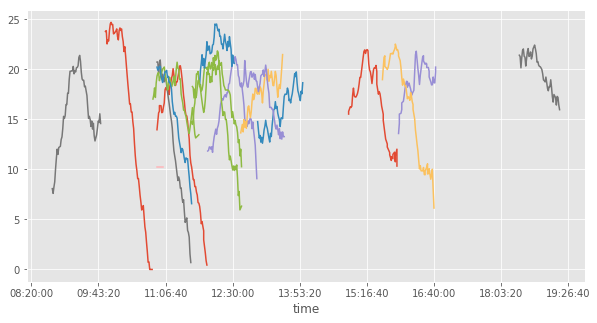

In [12]:
def plot_trip(trips, k):
    """ Plots the sliding average speed as a function of time 
    
    Args: 
        trip (list): list of trip DataFrames to plot
        k (int): the half-width of the sliding average window
    """
    plot_list = []
    for thisTrip in trips:
        thisTripSA = compute_sliding_averages(thisTrip['spd'],k)
        plot_list.extend(plt.plot(thisTrip.index.time, thisTripSA))
    return plot_list




lines = plot_trip(all_trips['61A'][:20], 15)
plt.show()


We can also gain information from overall trends from averaging many data points. In the following function, we will plot the average speed of all buses at regular time intervals throughout the day. 


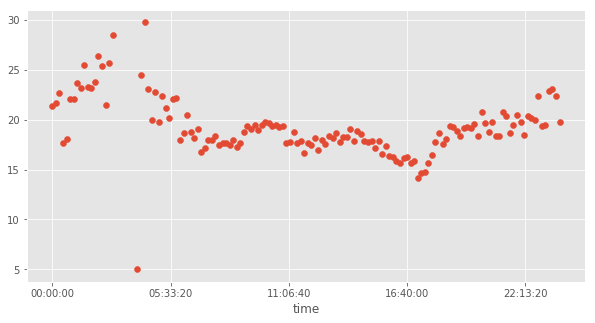

In [33]:
import datetime

def plot_avg_spd(df, t):
    """ Plot the average speed of all recorded buses within t minute intervals 
    Args: 
        df (pd.DataFrame): dataframe of bus data
        t (int): the granularity of each time period (in minutes) for which an average is speed is calculated
    """
    
    df['tmstmp'] = df["tmstmp"].apply(lambda this: this - datetime.timedelta(minutes=this.minute % t))
    df.loc[:,'time_bucket'] = pd.Series(np.random.randn(len(df['tmstmp'])), index=df.index)

    df['time_bucket'] = df["tmstmp"].apply(lambda this: this.time().strftime('%H:%M'))
    df['time_bucket'] = pd.to_datetime(df['time_bucket'], format='%H:%M').dt.time
    
    df1 = pd.DataFrame()
    df1['mean_'] = df.groupby(['time_bucket'])['spd'].mean()
    
    plot = plt.scatter(x= df1.index, y = df1.mean_)
    return plot
    

s = plot_avg_spd(vdf, 10)
plt.show()
